In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transform_helper

sph = transform_helper.StockReturn_Pooling_Helper()

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

sdrift = transform_helper.StockPrice_drift_Helper()
sdrift_df = sdrift.gen_prices(.000, .01, drift=.0015, level_init=10, num_returns=504)

fig_sdrift, axs_sdrift = sdrift.plot_data(sdrift_df, visible=False)
fig_sdrift_mean, axs_sdrift_mean = sdrift.plot_rolling(sdrift_df, window=30, visible=False)

# Create plots for shifted price
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig_sp, ax_sp = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax_sp)

plt.close(fig_sp)

# Create plots for relative price
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig_rp, ax_rp = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax_rp, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig_rp)

In [4]:
# Geron Housing Data example
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Data science in practice

Being a successful Data Scientist is much more than just knowing models.

Being able to gather, join, and clean Data is a prerequisite to being able to train a model.
- the remarkable success of Large Langauge Models (e.g., ChatGPT) is in large part due to vast quantities of carefully curated data

*Manipulating and transforming* the Data into a form in which a successful model can be built
is a skill that may not be truly appreciated.
- data is frequently transformed from its raw form to synthesized features and targets
- the relationship between features and target may not be present in raw form

It is this latter skill that we know focus on.

Recall the Fundamental Assumption of Machine Learning

- That each training and test example $(\x, \y)$ 
- is a sample drawn from $\pdata$
- where $\pdata$ is the true (but unknown) distribution of examples


It is surprisingly easy to violate this assumption

Consider the timeseries of prices of an equity

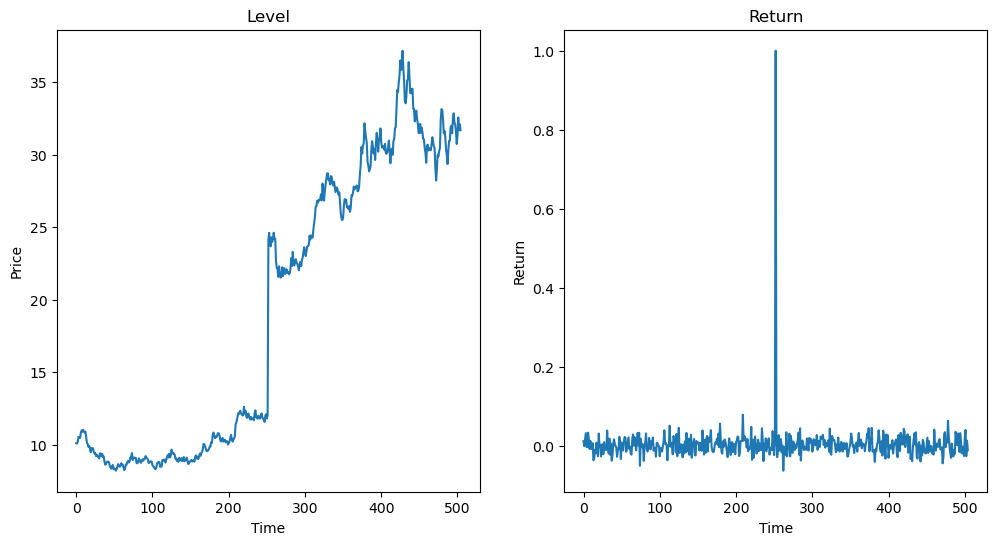

In [7]:
fig_data

One can easily see that there are two distributions here
- a low-mean (and low variance) distribution prior to the jump in Price
- a high-mean (and high variance) distribution after the jump

The test data (drawn post jump) is **not** from the same distribution as the training data (pre-jump).

In fact: if the training data also includes examples post-jump
- it would seem that the training data comes from the union of *two different* distributions

At first glance, this seems surprising.

After all, each Price is drawn from the distribution of a single equity.

But, as is very typical in Finance, our distributions *vary with time*.

A more common example:

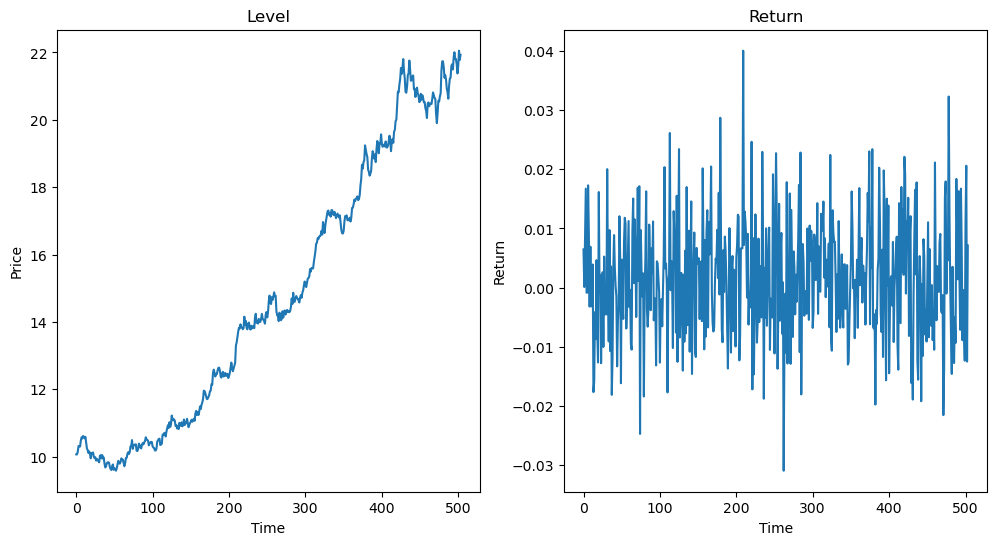

In [8]:
fig_sdrift

So, in order to satisfy the Assumption
- we typically transform the Price distribution into a Return distribution
- which is often (but not always) more stable over time

Converting into percent price changes (from levels) results in
- near constant mean/variance across examples

A dataset which was previously heterogeneous (in Levels)
- has become homogeneous (in Returns)

# Transformations to deal with time-varying or non-homogeneous data
The purpose of this section is
- to **motivate** Transformations
- from raw features to synthetic features
- such that the model's predictions work better

We will study the Transformations is a subsequent module


Many Transformations are motivated by the presence of examples
- that are not homogeneous
    - seem to come from different distributions

Often this occurs because the data varies over time.

We might have been surprised that Price (Level) data results in non-homogeneous examples.
- the ticker is the same
- but it's behavior over time has changed

There are many other variations of this problem.

Knowing how to recognize and correct them is important.

We will imagine that
- the available data comes from one or more *groups* each with its own distribution.

Let's go back to our original Regression problem
- predicting Price of an apartment from its Size

Consider the following graph illustrating the relationship between Price (target) and Size (features)

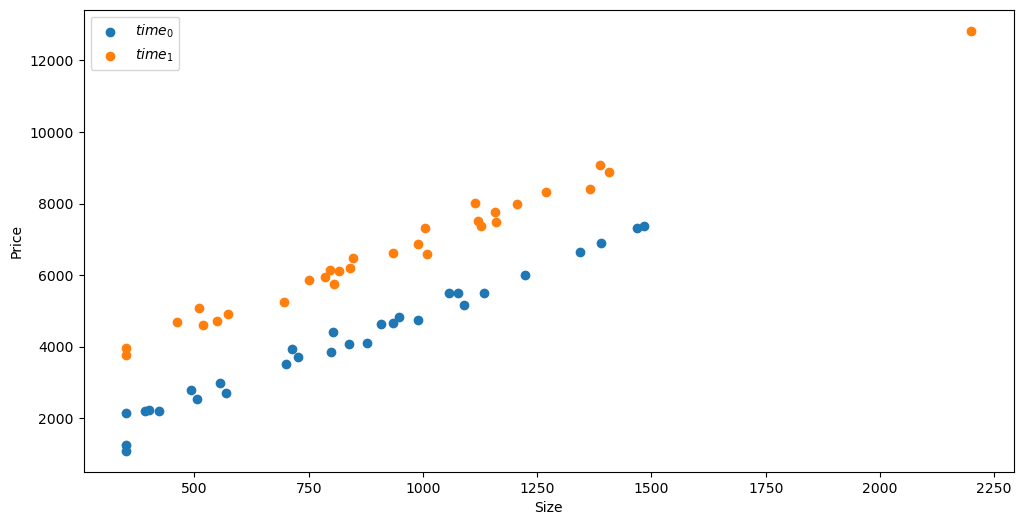

In [9]:
fig_sp

It appears that the data in different groups is similar, but not identical.
- relationship is linear within group
- same "slope" in both groups
- different per-group intercept

Once we make that observation
- We might be tempted to fit a *separate model* for each group.  This is not a great idea
    - Which model do we use for an out of sample example ?
    - The "goodness of fit" increases with sample size

But: how do we even **discover** the presence of two groups
- I added the colors for illustration
- In practice:
    - you are given a large dataset as a "cloud" of mixed examples
    - it might be up to **you** to discover that the single "cloud" of points represents two groups

There are multiple opportunities for a Data Scientist following the Recipe to uncover this
- Exploratory data analysis
    - slicing the data reveals different distributions
- Error Analysis
    - fitting a single line to all examples: the sign of the errors differs by group
    


Another reason for the presence of more than one group 
- differences in market/geography.

Consider the plot

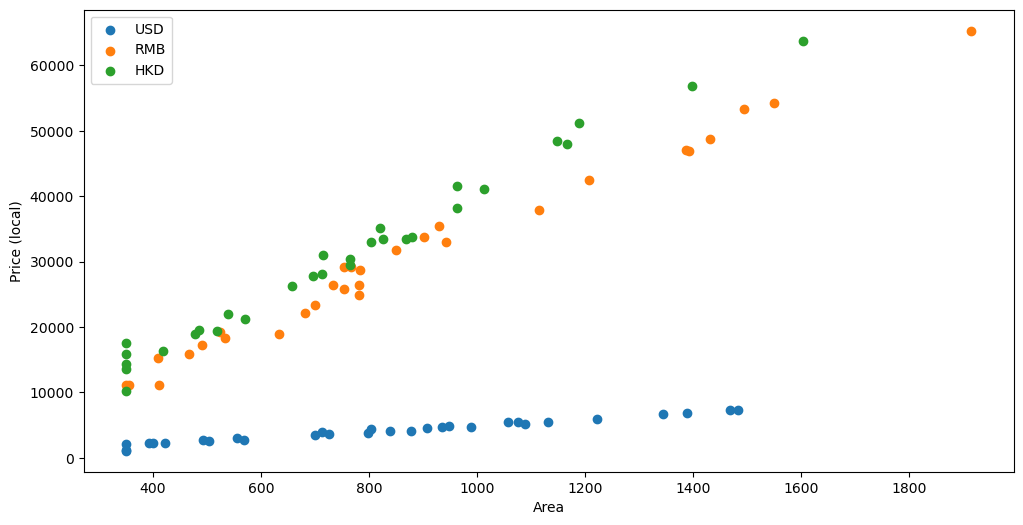

In [10]:
fig_rp

Again
- I have added the colors
- More typically: you have a cloud of points without any clear group distinction

Once you recognize the presence of multiple groups
- what can you do in this case ?

Each group seems to have a linear relationship between Price and Size.

Unlike the prior instance
- each group seems to have its own slope and intercept

Even though each group seems different **on the surface**
- there may be a *single* relationship between targets and features
- that is the *same* across groups
- at a **deeper** level

(We will reveal this common relationship after some time)

Being able to transform data to uncover the deeper level relationship between targets and features
- is a skill **critical to being able to construct good models**

# Transforming features to make them more predictive

## **Example: modeling prepayments**

We use plots from the following [notebook](Mortgage_Incentive_plots.ipynb) to illustrate.

Consider the following example.

Suppose our goal is to predict whether a borrower will prepay a mortgage.  

As raw features: we have variables
- Interest rate (coupon) $C$ on borrower's loan
- Rate $r$ at a which a mortgage could be re-financed

The borrower has an incentive to prepay if $C > r$.
- there are many other reasons for pre-payment
- we focus here only on reasons caused by changing interest rates

Let's examine the available features.

Consider the rate $C$ currently being paid by the borrower.

Is this predictive of the probability of prepaying ?



No ! 

Certainly not in isolation

Suppose $C = 5 \%$
- when the refinance rate $r > 5 \%$: no incentive
- when the refinance rate $r < 5 \%$: positive incentive

That is: the correlation between raw feature $r$ and the target (probability of prepaying) is not strong.

So the incentive to prepay is a joint function of $C$ and $r$.

Consider a different approach to modeling:
- we use a *synthetic* feature $I$  capturing *incentive* to prepay
- rather than just raw values $C, r$ for borrower's current rate and contemporaneous re-finance rate

For example, we could create feature $I$ in several possible ways
- $I = \max{}(0, C-r)$
    - incentive denominated in Percentage Points
- $I = \max{}(0, \frac{C}{r} -1)$
    - incentive denominated as relative to re-finance rate



The synthetic feature $I$ is much more likely to be correlated with the target.

Hence, a transformation from $C$ and $r$ to $I$ is more likely to result in a model with good predictions.

But there is *another* reason to use $I$

Suppose the current level of $r$ (test time) is at an extreme value versus history (training data)
- $r \lt \min{\x^\ip \in \X }{ \x^\ip_r }$ or $r \gt \min{\x^\ip \in \X }{ \x^\ip_r }$
- your trained model must *extrapolate* beyond the examples on which it was trained
    - the form of extrapolation depends on the model's functional form

Our out of sample examples would not be from the same distribution as the training examples !


Even if the current level of $r$ is rare in history (but not at an extreme)
- so could be from the same distribution as training
- we have few training examples on which to base the prediction when using $r$ as the feature

Synthetic $I$ is more likely to avert both issues
- there are many historical examples $i$ where features $\x_r^\ip, C^\ip$ having the same  Incentive $I$

For example, $I =  \max{}(0, C-r) = 1 \%$ occurs when

- $\x_r^\ip = 3\%, \, C^\ip = 4\%$ re-finance rate extremely low
- $\x_r^\ip = 8\%, \, C^\ip = 9\%$ re-finance rate extremely high
- $\x_r^\ip = 5\%, \, C^\ip = 6 \%$ 


Using the synthetic feature opens up the possibility of using a lot more historical data
- Many more historical episodes with a particular value of $\frac{C}{r}$ or $C-r$
- Compared to examples where the then-current re-finance rate equals today's rate $r$

Another advantage: It allows the model
- to work for examples with a range of values for $I$
- rather than the immediate need of examples where $r \approx r'$

In essence, re-denomination into Incentive $I$
- has allowed us to pool examples
    - over time
    - over different levels of re-finance rate

# Transforming data to make it more homogeneous/less time-varying ?

What are the causes of heterogeneity ?

Some are structural
- a single equity ticker with a relationships that varies with time

But sometimes they arise out of necessity
- We need large amounts of training examples to fit models
    - more data yields better models
    
This sometimes requires us to **pool** examples from multiple groups
- not enough data for a single equity ticker in a single time window
    - pool across time
    - pool across equity tickers
- not enough data in a single geography
    - pool across markets
    

For example, a lot of Financial data is sampled at low frequency (e.g., daily)
- So not a lot of data points for a single ticker in a short time period
- Pool over time to increase number of examples
    - groups caused by time-varying distribution of single stock price/return
- Pool over many similar tickers to increase number of examples
    - distribution per ticker is different

## **Example: equity trading volume (shares)**
   
It might be reasonable to hypothesize that
- the daily trading volume (or changes in volume) of an equity is a useful feature
- for predicting stock behavior
- stocks with high volume *appear* to be more liquid
- jumps in volume may be a signal


How should we measure the Volume of a ticker ?

The obvious unit of measurement is "number of shares".

In this section, we show why this *may not* be the best measure.

We use plots from this [notebook](NVDA_normalization.ipynb) to discuss alternative measures.

Suppose we use the measure for the raw features, i.e., "shares".

If we do so
- we may not discover a signal *solely* related to the ticker
- when market volume is high
    - the volume of all tickers is high
    
Thus, an unusually high volume as measured in "number of shares" may not be a valid trading signal.

By re-denominating the ticker's Volume 
- into units "fraction of total market volume"
$$
\text{relative volume}_j = \frac{\text{volume}_j}{\sum_{j' \in \mathbb{U}} \text{volume}_{j'}}
$$

- we remove the effect of changes in ticker volume solely related to changes in Market volume.

So now the volume of ticker $j$ can be measured at multiple times
- increasing the number of training examples
- without introducing heterogeneity 

A non-homogeneous measure of Volume has been made homogeneous !

This change of units is accomplished
- as a *Transformation* in our Recipe

## **Example: equity trading volume (relative volume)**

Another re-denomination is possible
- into units "fraction of ticker's tradable shares"

That is: what *fraction* of the ticker's available shares has traded.

$$
\text{fraction volume}_j = \frac{\text{volume}_j}{\text{shares outstanding}_j}{}
$$

This re-denomination might allow us to pool across two nearly-identical tickers
- same Market Cap
- but one with
    - twice the number of shares
        - and hence: likely twice the Volume when denominated in units of "number of shares"
    - but half the Price
       

This transformation of units also works for a single ticker
- that has had a Stock Split
    - doubling shares but halving price
- we can now pool across time

Again
- a Transformation into different units
- has allowed us to increase the number of training examples
- by pooling across multiple tickers
- without introducing heterogeneity

## **Example: equity trading volume (Dollar volume)**

Another common re-denomination of Volume is
- into units of "Dollar Volume*

$$
\text{Dollar Volume} = \text{Volume} * \text{Price}
$$

Often: this is used as a threshold to limit which Tickers to pool
- include a ticker only if it's Dollar Volume each day is "significant"

## **Which measure of Volume should we use ?**

We tried to verbally describe the advantages/disadvantages of each measure.

**But** recall the Fundamental Theorem of Machine Learning !

This requires that
- the examples we will encounter in the future (out-of-sample, "test")
- are from the same distribution as the examples on which we train

Do all measures satisfy this property ?


Using plots of the training and test distributions
- we will show that some measures *do not satisfy the Fundamental Theorem* !

So, we really *don't* have a choice of the measure !
- use the one that best satisfies the Theorem

Let's go back to the [notebook](NVDA_normalization.ipynb#Let's-assume-that-the-training-data-and-test-data-are-from-the-first/second-half.)


# The power of Pooling

Both the Mortgage and Equity Volume examples
- allowed us to combine data from multiple time periods
- into more uniform distributions

This is called **Pooling**

**Pooling data**
- over time
- over geographies
- over many tickers

Pooling increases the size of the training dataset
- and can result in better models

**This is particularly valuable in Finance**
- where sample sizes can be small
- because observations occur at low frequency (daily)

Moreover, in order for the pooled data to be homogeneous
- we have transformed the data or creates synthetic features.

Often, these synthetic features highlight
- the true *semantics/reason* of the problem (e.g., prepayment)
    - relationship between $C$ and $r$
- rather than *syntax/surface* reasons
    - absolute level of re-finance rate $r$
    
A model based on deeper meaning of features
- hopefully is more likely to generalize to out of sample examples

# Becoming a successful Data Scientist

The examples in this notebook illustrate the challenges that a Data Scientist encounters.

What distinguishes an "good" Data Scientist from a "great" one is the knowledge and skill to
recognize and circumvent the challenges.

**A key skill of a Data Scientist** is the ability
- to strip away surface differences and reveal underlying commonality between groups
- being able to adapt models to deal with multiple groups

You can *recognize* the challenge
- before starting: by superior Exploratory Data Analysis
- after staring: by superior Error Analysis

Once you recognize the challenges, you may be able to *circumvent* them by
- Transforming the data
    - imposing homogeneity
    - adding features that distinguish between groups
- Find the correct functional form for the model
    - linear
    - polynomial
    - something new

## The world before Black Scholes option pricing

The relationships between targets and features we have explored have usually been simple.

In the real world: the relationships are complex
- missing features
- interaction between features
- described by a new "theory" that is validated by data


Consider the goal of predicting the price of a call option from features of the option.

In the days before the Black Scholes pricing formula was discovered
- people proposed (partially successful) functional forms relating price to features
    - traders carried around tables of approximate prices
    - based on models that partially/conditionally explained prices

Even without a perfect model, an imaginative Data Scientist can come up with partially successful models
with high utility.

A Data Scientist needs
- intuition
- imagination
- scientific rigor and the will to experiment

in order to be able to postulate/test theories relating target to features.

A couple of observations on the Black Scholes call price formula

$$
C = \mathcal{N}(d_1) S_t + - \mathcal{N}(d_2)K * e^{- r*t }
$$
where
$$
\begin{array} \\
d_1 & = & \frac{ \log_e (\frac{S_t}{K}) + (r + .5*\sigma^2)*t
               }
               {
               \sigma * \sqrt{t}
               } 
               \\
d_2 & = & d_1 - \sigma * \sqrt{t}
\end{array}
$$

Notice some interesting "transformed features" in the $d_1$ term
- Price is denominated relative to the strike : $\frac{S_t}{K}$
- Volatility is scaled by time to maturity $t$: $\sigma * \sqrt{t}$

These non-obvious features derive, perhaps, from a need to "normalize" the feature.

# Wrap-up

Obviously, these examples were contrived and overly simple.

In practice, more complex transformations are necessary to make groups more homogeneous.

The insight of the Data Scientist is key in guiding the process.

We will show transformations that address each of these examples (and more) in a separate module.

In [11]:
print("Done")

Done
